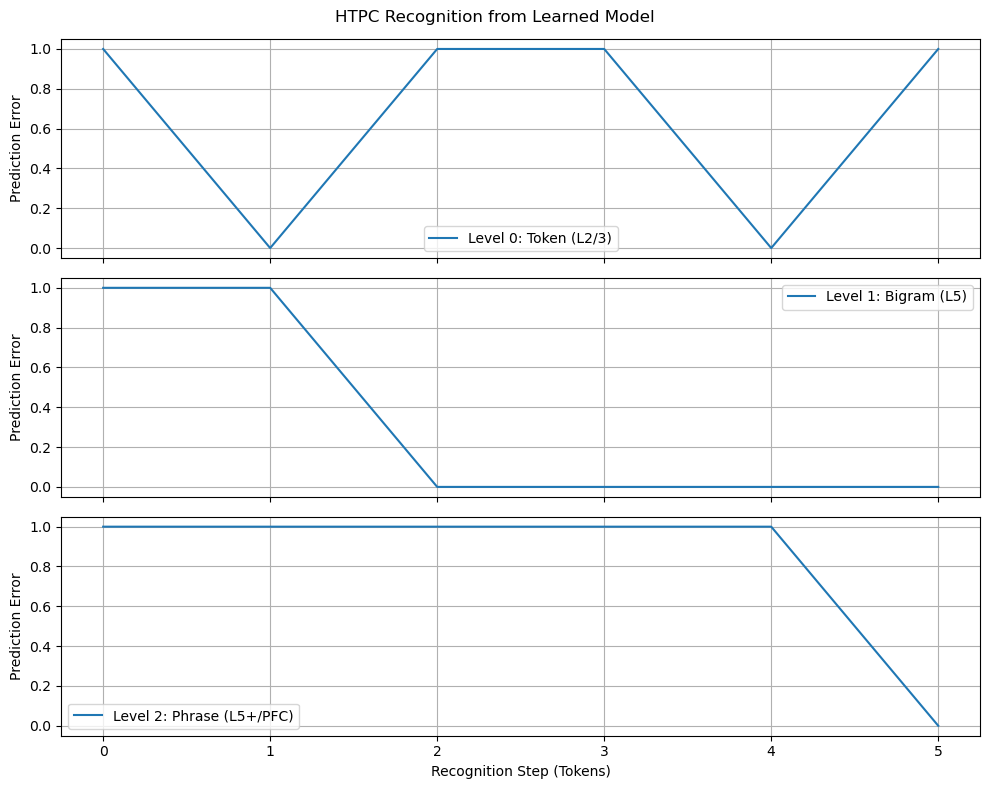

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# === Load HTPC model from JSON file ===
with open("htpc_model.json", "r") as f:
    json_model = json.load(f)

# === Reconstruct model structures ===

# Token transitions (Level 0)
token_transitions = json_model['token_transitions']

# Bigram memory (Level 1)
bigram_memory = {
    tuple(key.split("|||")): np.array(value)
    for key, value in json_model['bigram_memory'].items()
}

# Phrase memory (Level 2)
phrase_memory = {
    tuple(tuple(pair.split("__")) for pair in key.split("|||")): np.array(value)
    for key, value in json_model['phrase_memory'].items()
}

# === Input: Test sentence for recognition ===
test_sentence = ['the', 'dog', 'ran', 'in', 'the', 'park']
n_tokens = len(test_sentence)
n_levels = 3

# === Prediction and error tracking ===
level_predictions = [np.zeros(n_tokens) for _ in range(n_levels)]
prediction_errors = [[] for _ in range(n_levels)]

# === Recognition loop ===
for i, token in enumerate(test_sentence):
    actual = 1.0  # Input token observed

    # --- Level 0: token transition prediction ---
    predicted_token = None
    if i > 0:
        predicted_token = token_transitions.get(test_sentence[i - 1], None)
    low_pred = 1.0 if predicted_token == token else 0.0
    level_predictions[0][i] = low_pred
    prediction_errors[0].append(abs(actual - low_pred))

    # --- Level 1: bigram recognition ---
    bigram_pred_vector = np.zeros(n_tokens)
    if i > 0:
        bigram = (test_sentence[i - 1], token)
        if bigram in bigram_memory:
            bigram_pred_vector = bigram_memory[bigram]
    bigram_pred = bigram_pred_vector[i]
    level_predictions[1][i] = bigram_pred
    prediction_errors[1].append(abs(actual - bigram_pred))

    # --- Level 2: phrase recognition ---
    phrase_pred_vector = np.zeros(n_tokens)
    if i >= 5:
        phrase = tuple((test_sentence[j], test_sentence[j + 1]) for j in range(i - 5, i))
        for known_phrase, prediction in phrase_memory.items():
            if phrase == known_phrase:
                phrase_pred_vector = prediction
                break
    phrase_pred = phrase_pred_vector[i]
    level_predictions[2][i] = phrase_pred
    prediction_errors[2].append(abs(actual - phrase_pred))

# === Plotting prediction errors for all levels ===
fig, ax = plt.subplots(n_levels, 1, figsize=(10, 8), sharex=True)
labels = ['Level 0: Token (L2/3)',
          'Level 1: Bigram (L5)',
          'Level 2: Phrase (L5+/PFC)']

for lvl in range(n_levels):
    ax[lvl].plot(prediction_errors[lvl], label=labels[lvl])
    ax[lvl].set_ylabel("Prediction Error")
    ax[lvl].legend()
    ax[lvl].grid(True)

ax[-1].set_xlabel("Recognition Step (Tokens)")
plt.suptitle("HTPC Recognition from Learned Model")
plt.tight_layout()
plt.show()
